In [1]:
import pandas as pd
import numpy as np
from matplotlib import colors, cm, text, pyplot as plt
import matplotlib.patches as patches

In [2]:
from sklearn.cluster import DBSCAN

In [3]:
import peakutils
from scipy import signal
import math
import os

In [4]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = -1 * ((1.2 * mz_lower) - 1252)
    scan_for_mz_upper = -1 * ((1.2 * mz_upper) - 1252)
    return (scan_for_mz_lower,scan_for_mz_upper)

In [5]:
MZ_MIN = 748
MZ_MAX = 766

In [6]:
charge_one_scan_max = max(scan_coords_for_single_charge_region(mz_lower=MZ_MIN, mz_upper=MZ_MAX))

In [7]:
# constrain the data to re-run the same feature for debugging
MZ_MIN_DEBUG, MZ_MAX_DEBUG = (764.7345696042673, 769.7345696042673)
SCAN_MIN_DEBUG, SCAN_MAX_DEBUG = (498.0, 698.0)
RT_LOWER_DEBUG, RT_UPPER_DEBUG = (2.197688e+03-10, 2.197688e+03+10)

In [8]:
PROCESSED_INTENSITY_INDICATOR = -1

In [9]:
raw_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/YHE211_1-mz-748-766-rt-2000-2200.pkl')
raw_df = raw_df[(raw_df.frame_type == 0) & (raw_df.intensity >= 50) & (raw_df.scan >= charge_one_scan_max)]
# raw_df = raw_df[(raw_df.mz >= MZ_MIN_DEBUG) & (raw_df.mz <= MZ_MAX_DEBUG) & (raw_df.scan >= SCAN_MIN_DEBUG) & (raw_df.scan <= SCAN_MAX_DEBUG) & (raw_df.retention_time_secs >= RT_LOWER_DEBUG) & (raw_df.retention_time_secs <= RT_UPPER_DEBUG)]
raw_df.reset_index(drop=True, inplace=True)

In [10]:
# assign each point a unique identifier
raw_df['point_id'] = raw_df.index

In [11]:
CUBOIDS_FILE = '/Users/darylwilding-mcbride/Downloads/precursor-cuboids.pkl'
precursor_cuboids_l = []
# remove the cuboids file
if os.path.isfile(CUBOIDS_FILE):
    os.remove(CUBOIDS_FILE)
# a unique id for each precursor cuboid
precursor_cuboid_id = 1

#### repeat from here

In [68]:
# find the most intense point
anchor_point_s = raw_df.loc[raw_df.intensity.idxmax()]
anchor_point_s

frame_id                19762.000000
frame_type                  0.000000
mz                        756.406702
scan                      484.000000
intensity                3099.000000
retention_time_secs      2195.570569
point_id               507965.000000
Name: 507965, dtype: float64

In [69]:
mz_lower = anchor_point_s.mz - 1.0
mz_upper = anchor_point_s.mz + 7.0
scan_lower = anchor_point_s.scan - 100
scan_upper = anchor_point_s.scan + 100

In [70]:
candidate_region_df = raw_df[(raw_df.frame_id == anchor_point_s.frame_id) & (raw_df.mz >= mz_lower) & (raw_df.mz <= mz_upper) & (raw_df.scan >= scan_lower) & (raw_df.scan <= scan_upper)].copy()


In [71]:
MS1_PEAK_DELTA = 0.1

In [72]:
peak_mz_lower = anchor_point_s.mz-MS1_PEAK_DELTA
peak_mz_upper = anchor_point_s.mz+MS1_PEAK_DELTA

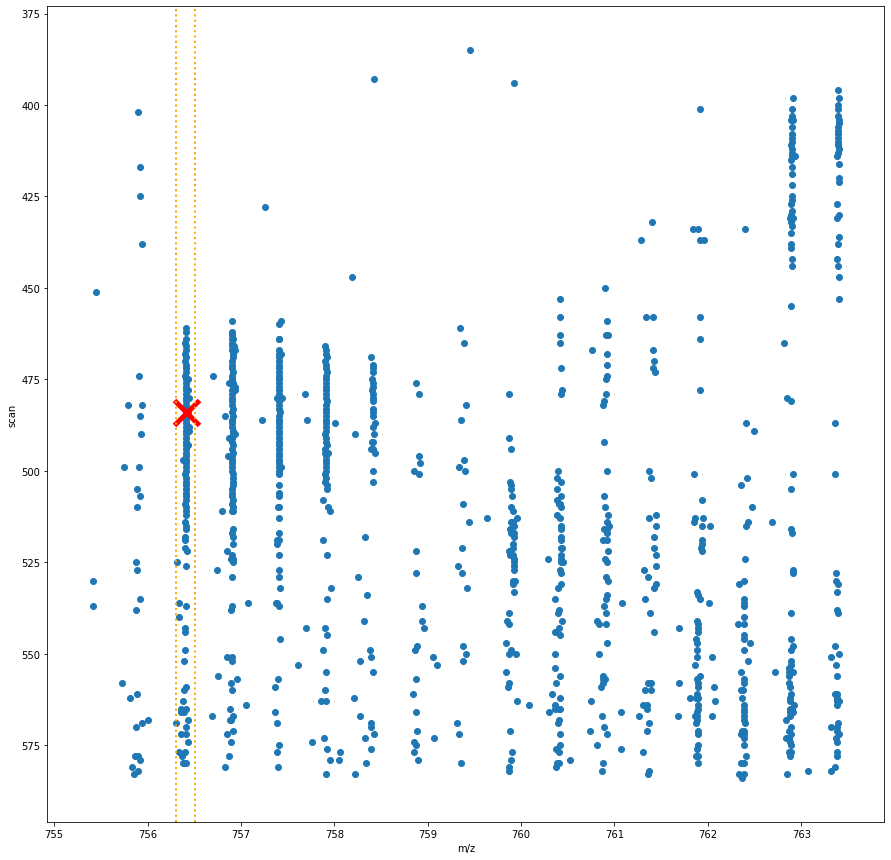

In [73]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(candidate_region_df.mz, candidate_region_df.scan)
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, label='anchor point')

plt.axvline(x=peak_mz_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=peak_mz_upper, linestyle=':', color='orange', linewidth=2)

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [74]:
peak_df = candidate_region_df[(candidate_region_df.mz >= peak_mz_lower) & (candidate_region_df.mz <= peak_mz_upper)]

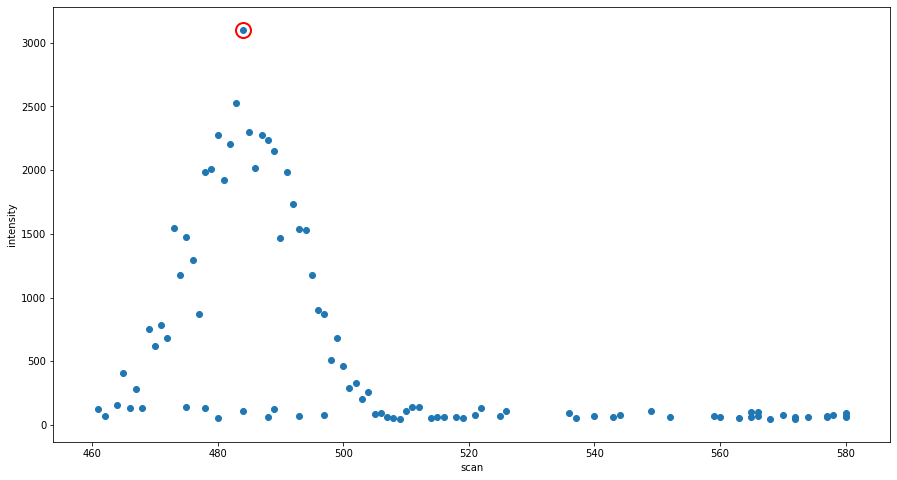

In [75]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(peak_df.scan, peak_df.intensity)
plt.plot(anchor_point_s.scan, anchor_point_s.intensity, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15, label='anchor point')

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

In [76]:
scan_0_df = peak_df.groupby(['scan'], as_index=False).intensity.sum()
scan_0_df.sort_values(by=['scan'], ascending=True, inplace=True)
# filter the points
scan_0_df['filtered_intensity'] = scan_0_df.intensity  # set the default
window_length = 21
if len(scan_0_df) > window_length:
    try:
        scan_0_df['filtered_intensity'] = signal.savgol_filter(scan_0_df.intensity, window_length=window_length, polyorder=2)
        filtered = True
    except:
        filtered = False
else:
    filtered = False

In [77]:
filtered

True

In [78]:
peak_idxs = peakutils.indexes(scan_0_df.filtered_intensity.values, thres=0.05, min_dist=10/2, thres_abs=False)
peak_x_l = scan_0_df.iloc[peak_idxs].scan.to_list()
peaks_df = scan_0_df[scan_0_df.scan.isin(peak_x_l)]

In [79]:
valley_idxs = peakutils.indexes(-scan_0_df.filtered_intensity.values, thres=0.05, min_dist=10/2, thres_abs=False)
valley_x_l = scan_0_df.iloc[valley_idxs].scan.to_list()
valleys_df = scan_0_df[scan_0_df.scan.isin(valley_x_l)]

In [80]:
valleys_df

,scan,intensity,filtered_intensity
47,509,50,61.901275
60,536,93,74.066035
68,560,61,79.887545


In [81]:
upper_x = valleys_df[valleys_df.scan > anchor_point_s.scan].scan.min()
if math.isnan(upper_x):
    upper_x = scan_0_df.scan.max()
lower_x = valleys_df[valleys_df.scan < anchor_point_s.scan].scan.max()
if math.isnan(lower_x):
    lower_x = scan_0_df.scan.min()

In [82]:
scan_0_extract_df = scan_0_df[(scan_0_df.scan >= lower_x) & (scan_0_df.scan <= upper_x)]

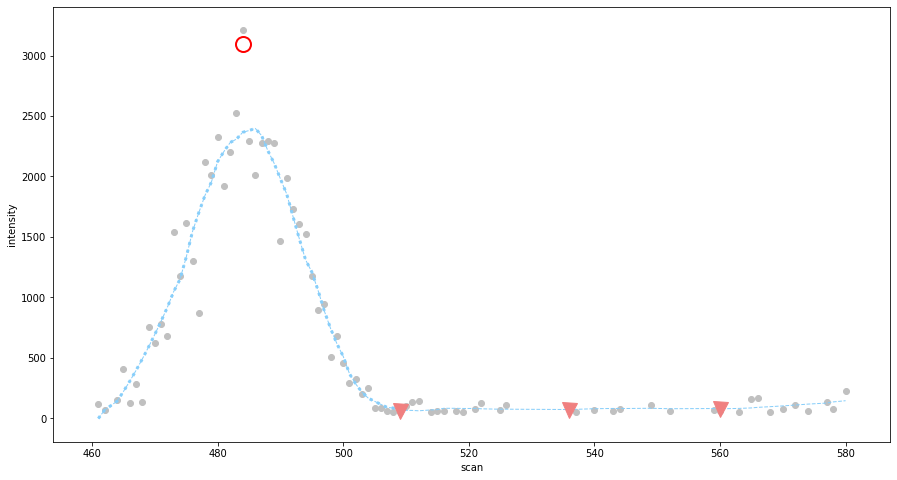

In [83]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(scan_0_df.scan, scan_0_df.intensity, c='silver')
# plot the smoothed points
plt.plot(scan_0_df.scan, scan_0_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')
plt.plot(scan_0_extract_df.scan, scan_0_extract_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.plot(valleys_df.scan, valleys_df.filtered_intensity, marker='v', color='lightcoral', linestyle=None, linewidth=0, ms=15, label='valleys')
plt.plot(anchor_point_s.scan, anchor_point_s.intensity, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15, label='anchor point')

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

#### trim the candidate region to account for the selected peak in mobility

In [84]:
candidate_region_df = candidate_region_df[(candidate_region_df.scan >= lower_x) & (candidate_region_df.scan <= upper_x)]

#### segment the raw data to reveal the isotopes in the feature

In [85]:
X = candidate_region_df[['mz','scan']].values

In [86]:
def custom_metric(r1, r2):
    mz_1 = r1[0]
    scan_1 = r1[1]
    mz_2 = r2[0]
    scan_2 = r2[1]
    if (abs(mz_1 - mz_2) <= 0.1) and (abs(scan_1 - scan_2) <= 5):
        result = 0.5
    else:
        result = 10
    return result;

In [87]:
# cluster the data
dbscan = DBSCAN(eps=1, min_samples=3, metric=custom_metric)
clusters = dbscan.fit_predict(X)

In [88]:
candidate_region_df['cluster'] = clusters

In [89]:
candidate_region_df.sample(n=5)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id,cluster
652778,19762,0,758.914754,498,70,2195.570569,652778,6
535868,19762,0,756.907117,479,1619,2195.570569,535868,2
594575,19762,0,757.917079,505,65,2195.570569,594575,4
536722,19762,0,756.911432,502,250,2195.570569,536722,2
507990,19762,0,756.406702,499,683,2195.570569,507990,1


In [90]:
number_of_point_clusters = len(candidate_region_df[candidate_region_df.cluster >= 0].cluster.unique())
print('found {} point clusters'.format(number_of_point_clusters))

found 12 point clusters


In [91]:
colour_map = plt.get_cmap('gist_ncar')
norm = colors.Normalize(vmin=candidate_region_df.cluster.min(), vmax=candidate_region_df.cluster.max(), clip=False)

In [92]:
# calculate the cluster centroids
centroids_l = []
for group_name,group_df in candidate_region_df.groupby(['cluster'], as_index=False):
    if group_name >= 0:
        mz_centroid = peakutils.centroid(group_df.mz, group_df.intensity)
        scan_centroid = peakutils.centroid(group_df.scan, group_df.intensity)
        centroids_l.append((group_name, mz_centroid, scan_centroid))
centroids_df = pd.DataFrame(centroids_l, columns=['cluster','mz','scan'])

In [93]:
# determine a colour for each cluster
cluster_colour_l = []
for group_name,group_df in candidate_region_df.groupby(['cluster'], as_index=False):
    c = colour_map(norm(group_name), bytes=False)[:3]
    cluster_colour_l.append((group_name, c))
cluster_colour_df = pd.DataFrame(cluster_colour_l, columns=['cluster','colour'])

In [94]:
# give each point a colour
candidate_region_df = pd.merge(candidate_region_df, cluster_colour_df, how='left', left_on=['cluster'], right_on=['cluster'])


In [95]:
candidate_region_df.sample(n=3)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id,cluster,colour
42,19762,0,756.406702,502,325,2195.570569,507992,1,"(0.0, 0.7752259284890427, 1.0)"
91,19762,0,756.907117,491,1599,2195.570569,535884,2,"(0.0, 0.9839560165597562, 0.6913351840736295)"
208,19762,0,757.917079,481,226,2195.570569,594567,4,"(0.4848257593233371, 0.9615101201771029, 0.0)"


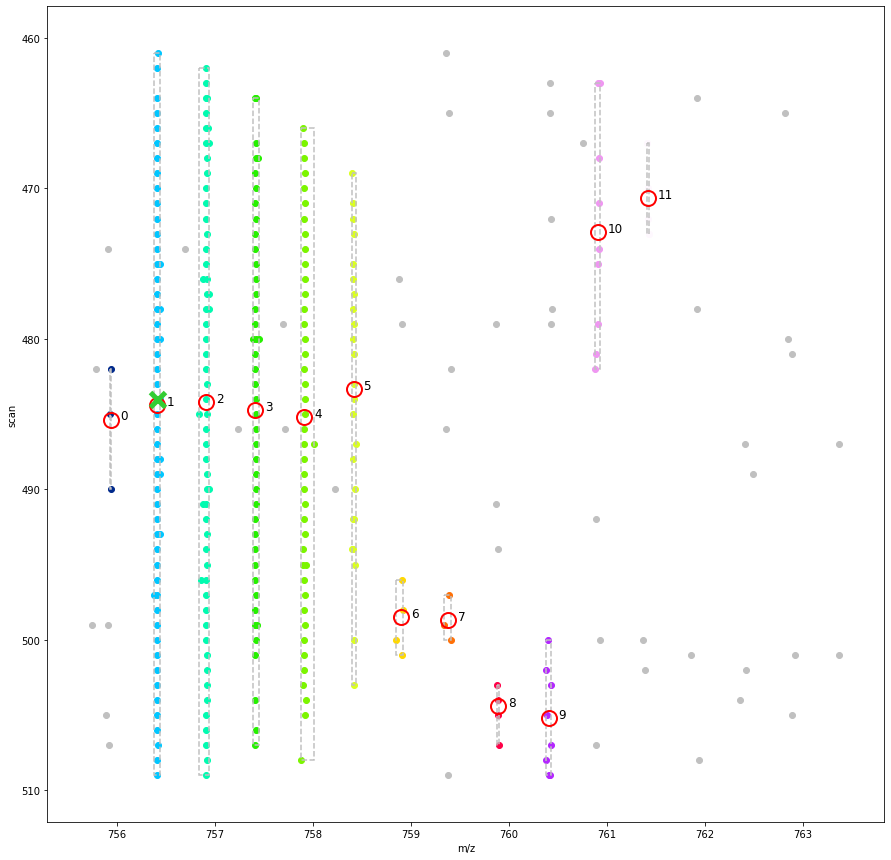

In [96]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

# plot the unassigned points
df = candidate_region_df[(candidate_region_df.cluster == -1)]
plt.scatter(df.mz, df.scan, c='silver')

df = candidate_region_df[(candidate_region_df.cluster >= 0)]
for group_name,group_df in df.groupby(['cluster'], as_index=False):
    # the raw points
    plt.scatter(group_df.mz, group_df.scan, c=np.array([group_df.iloc[0].colour]))
    # the cluster centroid
    centroid_s = centroids_df[(centroids_df.cluster == group_name)].iloc[0]
    plt.plot(centroid_s.mz, centroid_s.scan, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15)
    ax1.text(centroid_s.mz+0.1, centroid_s.scan, group_name, fontsize=12)
    # draw the cluster rectangle
    top_left = (group_df.mz.min(),group_df.scan.min())
    width = group_df.mz.max() - group_df.mz.min()
    height = group_df.scan.max() - group_df.scan.min()
    cluster_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='silver',facecolor='none')
    ax1.add_patch(cluster_rect)

# the anchor point for this candidate region
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='limegreen', linestyle='', markeredgewidth=5, ms=15, label='anchor point')

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [97]:
def isotope_metric(r1, r2):
    mz_1 = r1[0]
    scan_1 = r1[1]
    mz_2 = r2[0]
    scan_2 = r2[1]
    if (abs(mz_1 - mz_2) <= 0.8) and (abs(mz_1 - mz_2) > 0.1) and (abs(scan_1 - scan_2) <= 10):
        result = 0.5
    else:
        result = 10
    # print('r1={}, r2={}, result={}'.format(r1,r2,result))
    return result;

In [98]:
X = centroids_df[['mz','scan']].values

In [99]:
# cluster the data
dbscan = DBSCAN(eps=1, min_samples=2, metric=isotope_metric)
clusters = dbscan.fit_predict(X)
centroids_df['isotope_cluster'] = clusters

In [100]:
number_of_isotope_clusters = len(centroids_df[centroids_df.isotope_cluster >= 0].isotope_cluster.unique())
print('found {} isotope clusters'.format(number_of_isotope_clusters))

found 2 isotope clusters


In [101]:
candidate_region_df = pd.merge(candidate_region_df, centroids_df[['cluster','isotope_cluster']], how='left', left_on=['cluster'], right_on=['cluster'])


In [102]:
candidate_region_df.fillna(value=-1, inplace=True)
candidate_region_df.isotope_cluster = candidate_region_df.isotope_cluster.astype(int)

In [103]:
candidate_region_df.sample(n=3)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id,cluster,colour,isotope_cluster
239,19762,0,758.849950,500,66,2195.570569,641458,6,"(1.0, 0.8453289903210827, 0.004213010380622807)",1
14,19762,0,756.402389,501,293,2195.570569,507142,1,"(0.0, 0.7752259284890427, 1.0)",0
188,19762,0,757.908444,489,274,2195.570569,593270,4,"(0.4848257593233371, 0.9615101201771029, 0.0)",0


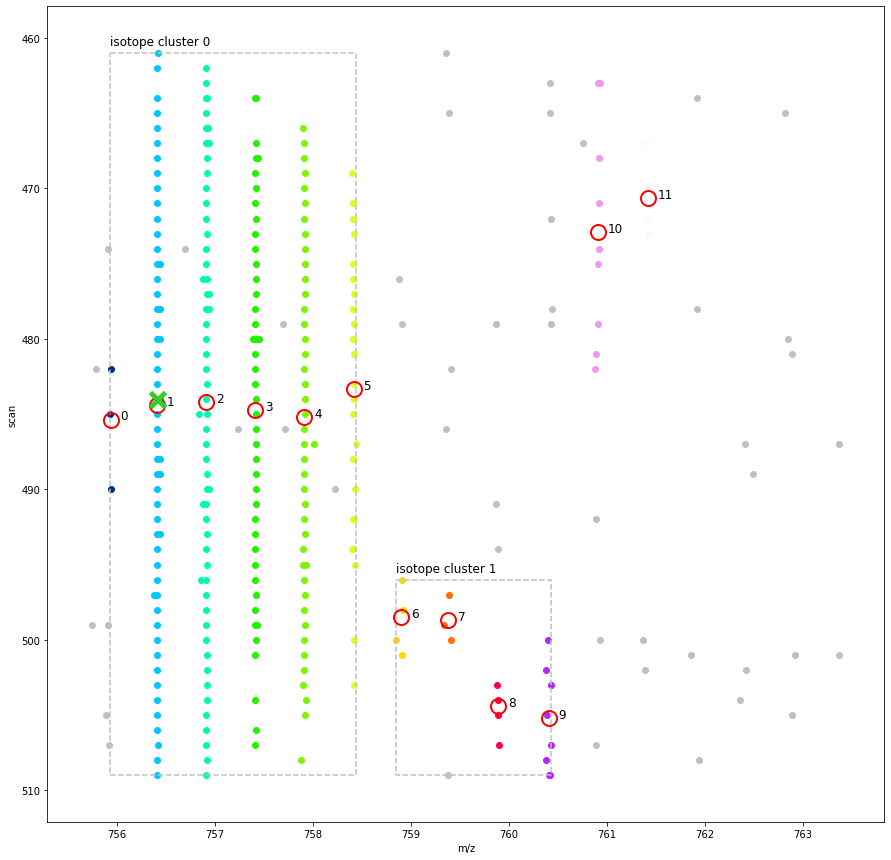

In [104]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

# plot the unassigned points
df = candidate_region_df[(candidate_region_df.cluster == -1)]
plt.scatter(df.mz, df.scan, c='silver')

df = candidate_region_df[(candidate_region_df.cluster >= 0)]
for group_name,group_df in df.groupby(['cluster'], as_index=False):
    # the raw points
    plt.scatter(group_df.mz, group_df.scan, c=np.array([group_df.iloc[0].colour]))
    # the cluster centroid
    centroid_s = centroids_df[(centroids_df.cluster == group_name)].iloc[0]
    plt.plot(centroid_s.mz, centroid_s.scan, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15)
    ax1.text(centroid_s.mz+0.1, centroid_s.scan, group_name, fontsize=12)

df = candidate_region_df[(candidate_region_df.isotope_cluster >= 0)]
for group_name,group_df in df.groupby(['isotope_cluster'], as_index=False):
    # draw the cluster rectangle
    top_left = (group_df.mz.min(),group_df.scan.min())
    width = group_df.mz.max() - group_df.mz.min()
    height = group_df.scan.max() - group_df.scan.min()
    cluster_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='silver',facecolor='none')
    ax1.add_patch(cluster_rect)
    ax1.text(top_left[0], top_left[1]-0.5, 'isotope cluster {}'.format(int(group_name)), fontsize=12)

# the anchor point for this candidate region
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='limegreen', linestyle='', markeredgewidth=5, ms=15, label='anchor point')

plot_xlim = ax1.get_xlim()
plot_ylim = ax1.get_ylim()

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

#### we now have the 2D extent of the feature - take that extent through time and see if we can cluster the centroids in time

In [105]:
# which cluster contains the anchor point?
anchor_point_s = candidate_region_df[(candidate_region_df.point_id == anchor_point_s.point_id)].iloc[0]


In [106]:
anchor_point_s

frame_id                                        19762
frame_type                                          0
mz                                            756.407
scan                                              484
intensity                                        3099
retention_time_secs                           2195.57
point_id                                       507965
cluster                                             1
colour                 (0.0, 0.7752259284890427, 1.0)
isotope_cluster                                     0
Name: 28, dtype: object

In [107]:
# get the extent of the isotope cluster in m/z and mobility
points_in_cluster_df = candidate_region_df[(candidate_region_df.isotope_cluster == anchor_point_s.isotope_cluster)]
mz_lower = points_in_cluster_df.mz.min()
mz_upper = points_in_cluster_df.mz.max()
scan_lower = points_in_cluster_df.scan.min()
scan_upper = points_in_cluster_df.scan.max()

In [108]:
RT_BASE_PEAK_WIDTH = 10

In [109]:
# get the left-most peak in the isotope cluster
monoisotopic_cluster_s = centroids_df.loc[centroids_df[(centroids_df.isotope_cluster == anchor_point_s.isotope_cluster)].mz.idxmin()]


In [110]:
mono_raw_points_df = raw_df[(raw_df.mz >= monoisotopic_cluster_s.mz-MS1_PEAK_DELTA) & (raw_df.mz <= monoisotopic_cluster_s.mz+MS1_PEAK_DELTA) & (raw_df.scan >= scan_lower) & (raw_df.scan <= scan_upper) & (raw_df.retention_time_secs >= anchor_point_s.retention_time_secs-RT_BASE_PEAK_WIDTH) & (raw_df.retention_time_secs <= anchor_point_s.retention_time_secs+RT_BASE_PEAK_WIDTH)]
rt_0_df = mono_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_0_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
# filter the points
rt_0_df['filtered_intensity'] = rt_0_df.intensity  # set the default
window_length = 11
if len(rt_0_df) > window_length:
    try:
        rt_0_df['filtered_intensity'] = signal.savgol_filter(rt_0_df.intensity, window_length=window_length, polyorder=3)
        filtered = True
    except:
        filtered = False
else:
    filtered = False

In [111]:
filtered

True

In [112]:
peak_idxs = peakutils.indexes(rt_0_df.filtered_intensity.values, thres=0.05, min_dist=10/2, thres_abs=False)
peak_x_l = rt_0_df.iloc[peak_idxs].retention_time_secs.to_list()
peaks_df = rt_0_df[rt_0_df.retention_time_secs.isin(peak_x_l)]

In [113]:
valley_idxs = peakutils.indexes(-rt_0_df.filtered_intensity.values, thres=0.05, min_dist=10/8, thres_abs=False)
valley_x_l = rt_0_df.iloc[valley_idxs].retention_time_secs.to_list()
valleys_df = rt_0_df[rt_0_df.retention_time_secs.isin(valley_x_l)]

In [114]:
valleys_df

,frame_id,retention_time_secs,intensity,filtered_intensity
5,19697,2188.692169,160,169.571096
9,19722,2191.337795,57,126.424242
12,19737,2192.924400,101,100.806527


In [115]:
upper_x = valleys_df[valleys_df.retention_time_secs > anchor_point_s.retention_time_secs].retention_time_secs.min()
if math.isnan(upper_x):
    upper_x = rt_0_df.retention_time_secs.max()
lower_x = valleys_df[valleys_df.retention_time_secs < anchor_point_s.retention_time_secs].retention_time_secs.max()
if math.isnan(lower_x):
    lower_x = rt_0_df.retention_time_secs.min()

In [116]:
rt_lower = lower_x
rt_upper = upper_x

In [117]:
rt_0_extract_df = rt_0_df[(rt_0_df.retention_time_secs >= lower_x) & (rt_0_df.retention_time_secs <= upper_x)]

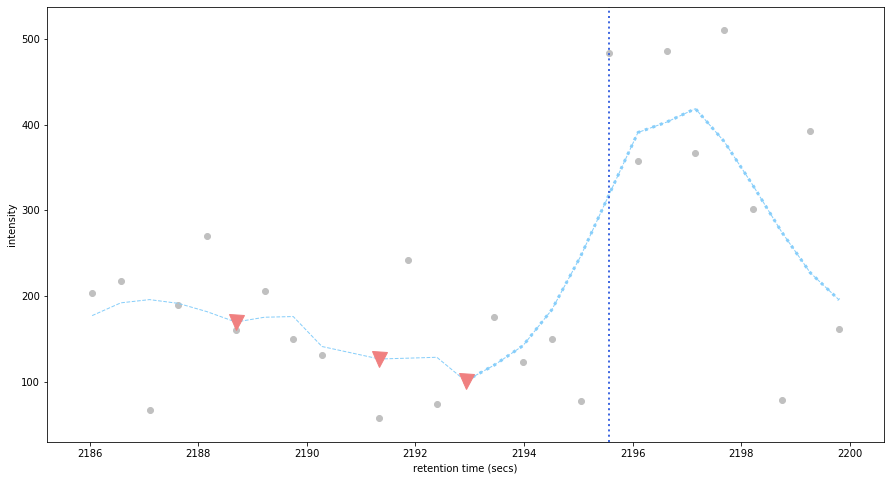

In [118]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(rt_0_df.retention_time_secs, rt_0_df.intensity, c='silver')
# plot the smoothed points
plt.plot(rt_0_df.retention_time_secs, rt_0_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')
plt.plot(rt_0_extract_df.retention_time_secs, rt_0_extract_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.plot(valleys_df.retention_time_secs, valleys_df.filtered_intensity, marker='v', color='lightcoral', linestyle=None, linewidth=0, ms=15, label='valleys')
plt.axvline(x=anchor_point_s.retention_time_secs, linestyle=':', color='royalblue', linewidth=2, label='anchor point')

plt.xlabel("retention time (secs)")
plt.ylabel("intensity")
plt.show()

In [119]:
# get the point ids
points_to_remove_l = raw_df[(raw_df.mz >= mz_lower) & (raw_df.mz <= mz_upper) & (raw_df.scan >= scan_lower) & (raw_df.scan <= scan_upper) & (raw_df.retention_time_secs >= rt_lower) & (raw_df.retention_time_secs <= rt_upper)].point_id.tolist()
# set the intensity so we don't process them again
raw_df.loc[raw_df.point_id.isin(points_to_remove_l), 'intensity'] = PROCESSED_INTENSITY_INDICATOR

In [120]:
len(raw_df[(raw_df.intensity == PROCESSED_INTENSITY_INDICATOR)])

7657

In [121]:
mz_lower, mz_upper

(755.9236991006879, 758.4352697463237)

In [122]:
scan_lower, scan_upper

(461, 509)

In [123]:
rt_lower, rt_upper

(2192.924400148333, 2199.8037915865807)